In [26]:
# !pip install tensorflow_datasets

In [27]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [28]:
# load model
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

In [29]:
class_names = info.features['label'].names

In [30]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [31]:
for i, example in enumerate(dataset['train']):
  image, label = example
  save_dir = 'tf_flowers/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)
  filepath = save_dir +'/' + class_names[label] + str(i) + '.jpg'
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())

## Data Visualization

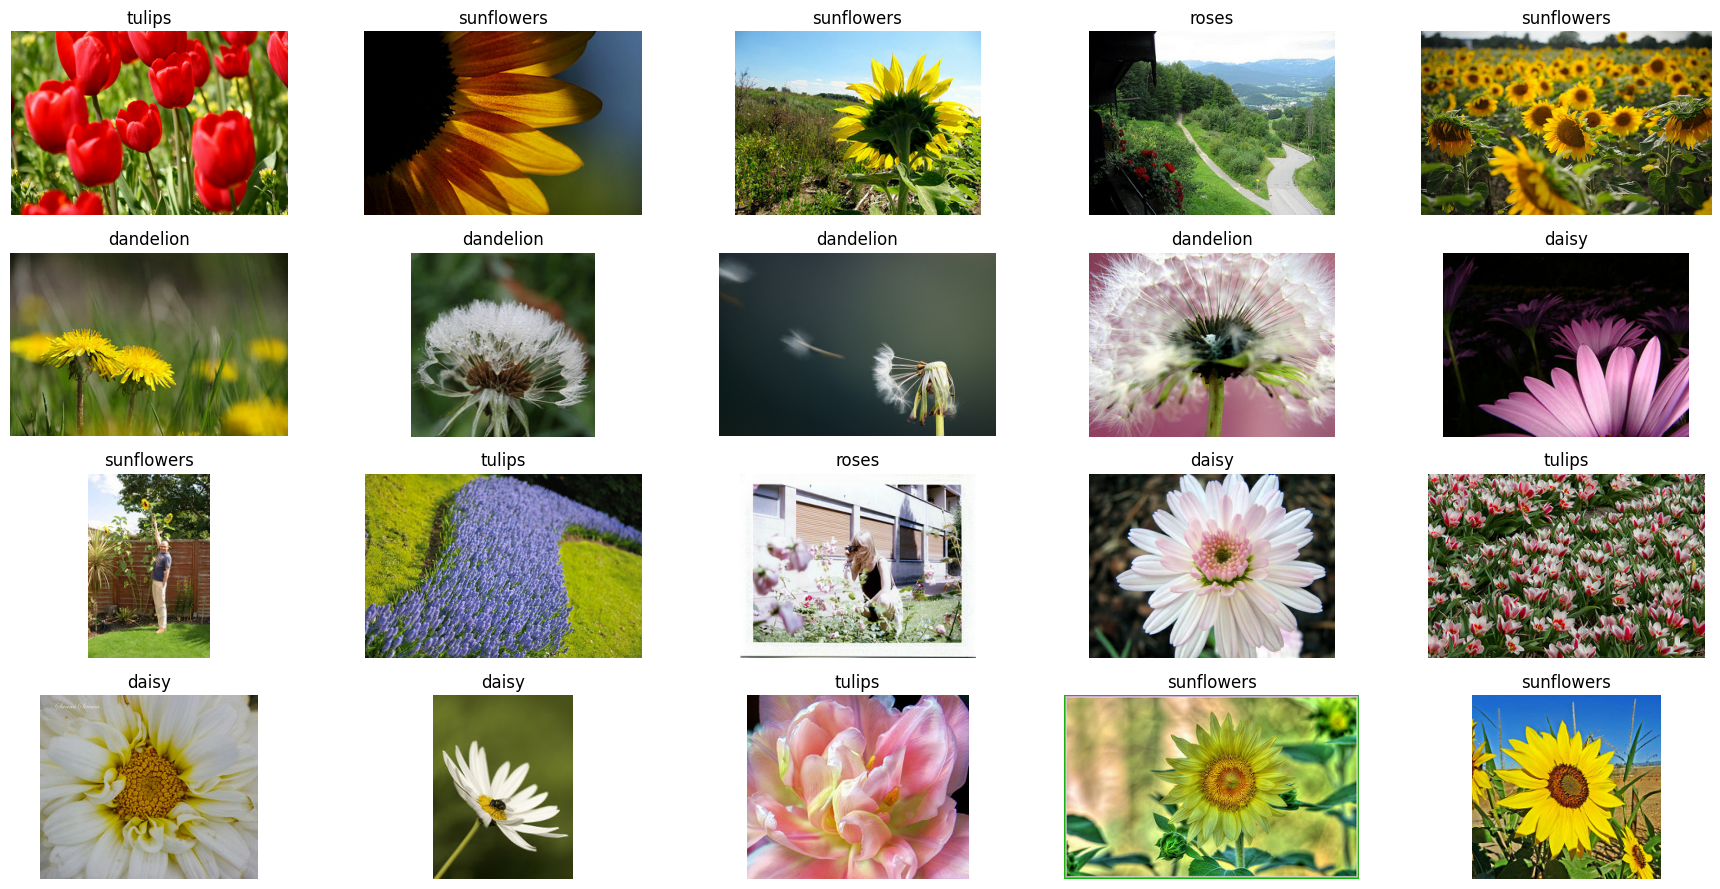

In [32]:
# iterate over 20 random image sample from the dataset

data = dataset['train'].take(20)
fig, ax = plt.subplots(4,5, figsize=(18, 9))
ax = ax.ravel()

for i, example in enumerate(data):
  image, label = example
  image = image.numpy()
  ax[i].imshow(image)
  ax[i].set_title(class_names[label])
  ax[i].axis('off')
plt.tight_layout()

## Preparing Data with Image Data Augmentation for Base Classifier

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255, validation_split = 0.2)
train_generator = datagen.flow_from_directory('tf_flowers', target_size = (224, 224), batch_size=32, class_mode='categorical', subset='training')
validation_generator = datagen.flow_from_directory('tf_flowers', target_size = (224, 224), batch_size=32, class_mode='categorical', subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [34]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

## Building Model for Base Classifier

In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
def get_base_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), input_shape=(224, 224, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(5, activation='softmax'))

  return model

model = get_base_model()

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

## Train Model with TFDS Data Without Saving Locally in your Directory

In [37]:
split_data, info = tfds.load('tf_flowers',  split=['train[:80%]', 'train[80%:]'],with_info=True, as_supervised=True)

In [38]:
train_dataset, validation_dataset = split_data

In [39]:
batch_size = 32
image_size = (224, 224)

In [40]:
def preprocess(image, label):
  image = tf.image.resize(image, image_size)
  image = tf.cast(image, tf.float32)/255
  return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

model = get_base_model()

In [41]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs = 5, validation_data = validation_dataset)

Epoch 1/5
92/92 [==============================] - 16s 152ms/step - loss: 1.4693 - accuracy: 0.4431 - val_loss: 1.0957 - val_accuracy: 0.5695
Epoch 2/5
92/92 [==============================] - 6s 69ms/step - loss: 0.9649 - accuracy: 0.6209 - val_loss: 0.9500 - val_accuracy: 0.6294
Epoch 3/5
92/92 [==============================] - 7s 72ms/step - loss: 0.7159 - accuracy: 0.7422 - val_loss: 1.0103 - val_accuracy: 0.6403
Epoch 4/5
92/92 [==============================] - 6s 65ms/step - loss: 0.5063 - accuracy: 0.8171 - val_loss: 1.2970 - val_accuracy: 0.5995
Epoch 5/5
92/92 [==============================] - 6s 66ms/step - loss: 0.3671 - accuracy: 0.8716 - val_loss: 1.5435 - val_accuracy: 0.6076


## Model Improvement with Augmentation and VGG16 network

In [42]:
from tensorflow.keras.applications.vgg16 import VGG16

In [43]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2, rotation_range=0.1, width_shift_range=0.1,
                             horizontal_flip=True, zoom_range=0.1, shear_range=0.1, height_shift_range=0.1)

train_generator = datagen.flow_from_directory('tf_flowers', target_size=(224, 224), batch_size=8, subset='training', class_mode='categorical')
valiadtion_generator = datagen.flow_from_directory('tf_flowers', target_size=(224, 224), batch_size=8, subset='validation', class_mode='categorical')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


## Make CNN model with VGG16 Transfer Learning

In [44]:
model_vgg16 = VGG16(input_shape=(224, 224, 3), include_top= False, weights='imagenet')

In [45]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
# set trainable parameters to zero (0)
for layer in model_vgg16.layers:
  layer.trainable=False

# add top layer
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               12845568  
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 5, validation_data = validation_generator)

Epoch 1/5
368/368 [==============================] - 53s 142ms/step - loss: 1.1731 - accuracy: 0.6662 - val_loss: 0.5470 - val_accuracy: 0.8126
Epoch 2/5
368/368 [==============================] - 55s 149ms/step - loss: 0.5880 - accuracy: 0.7863 - val_loss: 0.4963 - val_accuracy: 0.8194
Epoch 3/5
368/368 [==============================] - 69s 188ms/step - loss: 0.4661 - accuracy: 0.8302 - val_loss: 0.5512 - val_accuracy: 0.7934
Epoch 4/5
368/368 [==============================] - 61s 166ms/step - loss: 0.4221 - accuracy: 0.8486 - val_loss: 0.5552 - val_accuracy: 0.8126
Epoch 5/5
368/368 [==============================] - 54s 146ms/step - loss: 0.3665 - accuracy: 0.8714 - val_loss: 0.5596 - val_accuracy: 0.8030


## Save and Load model with class names

In [49]:
class_names = {v:k for k,v in train_generator.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [50]:
import pickle as pkl

In [51]:
data_model = {'class_names': class_names, 'model': model}
pkl.dump(data_model, open('model.pkl', 'wb'))

In [52]:
# load model
loaded_model = pkl.load(open('model.pkl', 'rb'))
loaded_model

{'class_names': {0: 'daisy',
  1: 'dandelion',
  2: 'roses',
  3: 'sunflowers',
  4: 'tulips'},
 'model': <keras.src.engine.sequential.Sequential at 0x7f3388336470>}

In [53]:
loaded_class_names = loaded_model['class_names']
loaded_model = loaded_model['model']

## Online Prediction of Flowers

In [54]:
import requests
from PIL import Image
from io import BytesIO

In [56]:
url_link = 'https://m.media-amazon.com/images/I/41rwKMqvKaL._SX300_SY300_QL70_ML2_.jpg'
response = requests.get(url_link)
img = Image.open(BytesIO(response.content)).resize((224, 224))
img = np.reshape(img, [1, 224, 224, 3])
img = img/255

In [58]:
preds = loaded_model.predict(img)
max_idx = np.argmax(preds[0])
loaded_class_names[max_idx], preds[0][max_idx]

1/1 [==============================] - 0s 35ms/step


('roses', 0.9843635)